In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import physics as phys
import utilities as utils
import spectrum as spec
import transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm

In [3]:
log_rs = np.log(4) + (np.arange(50)+1)*(np.log(31) - np.log(4))/50
log_rs = np.flipud(log_rs)

mmin = 5e3
mmax = 1e13
nwimpsteps = 40
mwimp = mmin*np.exp((np.arange(nwimpsteps))*np.log(mmax/mmin)/nwimpsteps)
mwimpmax = mwimp[-1]

nengsteps = 500
lowinjE = 3e3 + 100.
eng = lowinjE*np.exp((np.arange(nengsteps)*np.log(mwimpmax/lowinjE)/nengsteps))

In [4]:
tf_raw = np.load('/Users/hongwan/Dropbox (MIT)/transferfunction.npy')
tf_raw = np.swapaxes(tf_raw,0,1)
tf_raw = np.swapaxes(tf_raw,1,2)
tf_raw = np.swapaxes(tf_raw,2,3)
tf_raw = np.flip(tf_raw,axis=0)
# Claim: tf ordering is now (1+z, xe, outE, injE), redshift in decreasing order.
print(tf_raw.shape)

#tf_raw_list is an array of dimensions [N_injE, N_rs, N_outE].  
tf_raw_list =[[spec.Spectrum(eng, tf_raw[i,0,:,j], np.exp(log_rs[i])) for i in np.arange(tf_raw.shape[0])] 
            for j in np.arange(tf_raw.shape[-1])]
#transfer_func_table is a list of length N_injE, each with a Transferfunction object, with rs and outE as abscissa.
transfer_func_table = [tf.Transferfunction(spec_list) for spec_list in tf_raw_list]

(50, 1, 500, 500)


In [5]:
#Normalize each transfer_func in transfer_func_table by dN/dE of a single particle of injE. 
#Two particles injected initially. 
dNdE_norm = spec.rebin_N_arr(np.ones(eng.size), eng, eng)

for i in np.arange(eng.size):
    transfer_func_table[i] /= (2*dNdE_norm.dNdE[i])

In [6]:
#Initialize
start_mwimp = eng[299]
rs_list = np.exp(np.arange(log_rs[0], log_rs[-1], -0.002))

photon_spec_init = spec.rebin_N_arr(np.array([1]), np.array([eng[299]]), eng)
photon_spec_init.rs = rs_list[0]

In [7]:
print(rs_list)

[ 31.          30.93806196  30.87624767 ...,   4.18701138   4.17864572
   4.17029678]


In [8]:
photon_spectra = spec.Spectra([photon_spec_init])

append = photon_spectra.append

for rs in tqdm(rs_list):
    tf_at_rs = tf.Transferfunction([transfer_func.at_rs(rs) for transfer_func in transfer_func_table]) 
    append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs  

  0%|          | 0/1004 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object is not iterable

In [ ]:
photon_spectra = spec.Spectra([photon_spec_init])
append = photon_spectra.append

# List of transfer functions interpolated at rs_list, indexed by injection energy.
tf_at_rs_list = [transfer_func.at_rs(rs_list) for transfer_func in tqdm(transfer_func_table)]

for i in tqdm(np.arange(rs_list.size)):
    tf_at_rs = spec.Spectra([tf[i] for tf in tf_at_rs_list])
    append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs


 21%|██        | 103/500 [03:05<1:11:50, 10.86s/it]

In [29]:
file = fits.open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits")

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [30]:
file_spectra = spec.Spectra([spec.Spectrum(file_eng, photspec, rs) 
                             for photspec,rs in zip(file_photonspectrum, file_rs)])

In [31]:
file_spectra.rebin(eng)

In [32]:
file_spectra.rs

array([ 31.        ,  30.96901549,  30.93806196, ...,   4.00677711,
         4.00277233,   3.99877156])

13.9570841604
13.9570841604


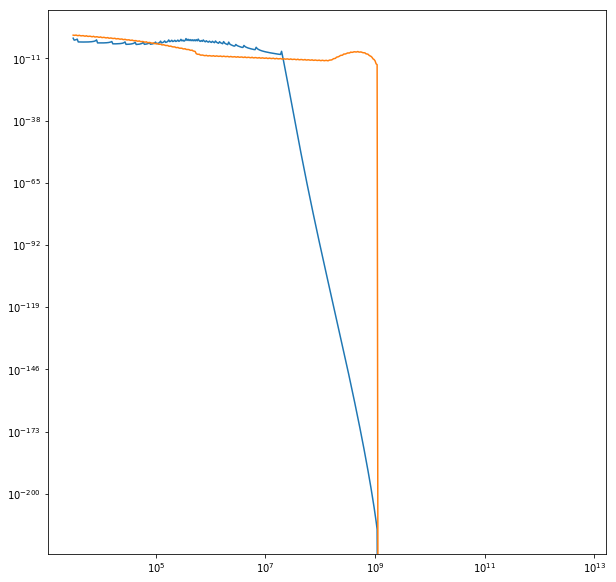

In [36]:
i=400
j=(i-1)*2
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

ax = plt.subplot(1,1,1)
plt.plot(photon_spectra.eng, photon_spectra[i].dNdE)
plt.plot(file_spectra.eng, file_spectra[j].dNdE)
ax.set_xscale('log')
ax.set_yscale('log')
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')